In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''
        Saves model when validation loss decrease.
        '''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [4]:
class PriceVolPredict:
    def __init__(self, path='./price_vol_filledNa.csv'):
        self.df = pd.read_csv(path, index_col=0)
    
    @staticmethod
    def ColSelector(df: pd.DataFrame, series=None, toker_list=None):
        cols = df.columns
        res = []
        if series and toker_list:
            res = [x for x in cols if x.split('-')[0] in toker_list and x.split('-')[1] in series]
        elif series:
            res = [x for x in cols if x.split('-')[1] in series]
        elif toker_list:
            res = [x for x in cols if x.split('-')[0] in toker_list]
        return res    
    
    def train_test(self, test_size=0.1):
        # X = self.df.drop(columns=['BTC-close', 'BTC-open', 'BTC-high', 'BTC-low']).shift(1).iloc[1:, :]
        X = self.df.shift(1).iloc[1:, :]
        Y = (self.df[['BTC-close']].iloc[1:, :] > 0)
        return train_test_split(X, Y, test_size = 0.1, shuffle=False)
    
    @staticmethod
    def backtest(real_return, signal):
        """
        This is a basic version of backtesting, where signal 1 represents buy/hold whereas 
        signal 0 represents sell/emtpy. The starting amount is 1. 
        """
        strategy = (signal * (1 + real_return)).cumprod()
        benchmark = (1 + real_return).cumprod()
        return pd.DataFrame({"benchmark": benchmark, "strategy": strategy}).plot()
    
    @staticmethod
    def Generate3D(X_df, Y_df, lag = 96):
        X = []
        for col in X_df.columns:
            temp = X_df[[col]].copy()
            for i in range(1, lag+1):
                temp[str(i) + col] = temp[col].shift(i)
            temp = temp.iloc[lag:, :]
            X.append(temp.values)
        X = np.array(X)
        X = np.swapaxes(X, 0, 1)
        X = np.swapaxes(X, 1, 2)

        return X, np.array(Y_df.iloc[lag:, :])

In [5]:
p_v = PriceVolPredict()
X_train_all, X_test, Y_train_all, Y_test = p_v.train_test()
X_train_all.shape, X_test.shape, Y_train_all.shape, Y_test.shape

((15750, 250), (1750, 250), (15750, 1), (1750, 1))

In [6]:
n_lag = 96
X_train_all, Y_train_all = PriceVolPredict.Generate3D(X_train_all, Y_train_all)
X_test, Y_test = PriceVolPredict.Generate3D(X_test, Y_test)

In [7]:
X_train_pt = torch.from_numpy(X_train_all).type(torch.Tensor)
X_test_pt = torch.from_numpy(X_test).type(torch.Tensor)
Y_train_pt = torch.from_numpy(Y_train_all).type(torch.Tensor)
Y_test_pt = torch.from_numpy(Y_test).type(torch.Tensor)

In [8]:
class CustomDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        return self.X[idx, :, :], self.Y[idx]

In [9]:
n = X_train_all.shape[0]

TrainSet = CustomDataset(X_train_all[:int(0.8*n), :, :], Y_train_all[:int(0.8*n), :])
TrainLoader = DataLoader(TrainSet, batch_size=32, shuffle=False)

ValidSet = CustomDataset(X_train_all[int(0.8*n):, :, :], Y_train_all[int(0.8*n):, :])
ValidLoader = DataLoader(ValidSet, batch_size=1, shuffle=False)

TestSet = CustomDataset(X_test, Y_test)
TestLoader = DataLoader(TestSet, batch_size=1, shuffle=False)

In [10]:
class LSTM1(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM1, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 64) #fully connected 1
        self.fc = nn.Linear(64, num_classes) #fully connected last layer
    
    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_() #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = F.relu(hn)
        out = F.relu(self.fc_1(out)) #first Dense
        out = F.sigmoid(self.fc(out)) #Final Output
        return out

In [11]:
num_epochs = 50 #1000 epochs
learning_rate = 0.005 #0.001 lr

input_size = 250 #number of features
hidden_size = 128 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 

In [12]:
lstm1 = LSTM1(num_classes, 
              input_size, 
              hidden_size, 
              num_layers, 
              X_train_pt.shape[1])

criterion = torch.nn.BCELoss(reduction='sum')
optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)


In [13]:
# for epoch in range(num_epochs):
#     outputs = lstm1.forward(X_train_pt) #forward pass
#     optimizer.zero_grad() #caluclate the gradient, manually setting to 0
 
#     # obtain the loss function
#     loss = criterion(outputs, Y_train_pt.float())
 
#     loss.backward() #calculates the loss of the loss function
#     optimizer.step() #improve from loss, i.e backprop
#     print("Epoch: %d, loss: %1.10f" % (epoch, loss.item())) 

In [16]:
def training_loop(n_epochs, optimizer, model, loss_fn, trainloader, validloader):
    train_loss_ls, valid_loss_ls = [], []
    early_stopping = EarlyStopping(patience=7, verbose=True)
    for epoch in range(1, n_epochs + 1):
        model.train()
        num_train = 0
        total_loss_train = 0
        for train_inputs, train_labels in trainloader:
            optimizer.zero_grad()
            train_inputs = train_inputs.float()
            train_labels = train_labels.float()
            t_p_train = model(train_inputs)
            loss_train = loss_fn(t_p_train, train_labels)
            num_train += train_inputs.size(0)
            total_loss_train += loss_train.item()
            loss_train.backward()
            optimizer.step()
        train_loss_ls.append(total_loss_train/num_train)
        print(f"train loss: {total_loss_train/num_train}", end=';')
        
        model.eval()
        num_valid = 0
        total_loss_valid = 0
        with torch.no_grad():
            for valid_input, valid_label in validloader:
                valid_input = valid_input.float()
                valid_label = valid_label.float()
                valid_hat = model(valid_input)
                loss_val = loss_fn(valid_hat, valid_label)
                num_valid += valid_input.size(0)
                total_loss_valid += loss_val.item()
        valid_loss_ls.append(total_loss_valid/num_valid)
        print(f"Validation loss: {total_loss_valid/num_valid}")
        early_stopping(total_loss_valid/num_valid, model)
        if early_stopping.early_stop:
            print("Early stopping")
            break
    model.load_state_dict(torch.load('checkpoint.pt'))
    return model, train_loss_ls, valid_loss_ls
                
                
#         t_p_val = model(t_u_val)
#         loss_val = loss_fn(t_p_val, t_c_val)
        
#         optimizer.zero_grad()
#         loss_train.backward()
#         optimizer.step()

In [17]:
lstm1, train_loss_ls, valid_loss_ls = training_loop(num_epochs,
              optimizer, 
              lstm1,
              criterion,
              TrainLoader,
              ValidLoader)

train loss: 0.6440688220207411;Validation loss: 0.7397898440053318
Validation loss decreased (inf --> 0.739790).  Saving model ...
train loss: 0.6355093373264604;Validation loss: 0.7233093790302463
Validation loss decreased (0.739790 --> 0.723309).  Saving model ...
train loss: 0.6298309200670376;Validation loss: 0.7519167775372403
EarlyStopping counter: 1 out of 7
train loss: 0.6247188099693074;Validation loss: 0.7359566136180916
EarlyStopping counter: 2 out of 7
train loss: 0.621855152821299;Validation loss: 0.765319409243675
EarlyStopping counter: 3 out of 7
train loss: 0.6202274554550462;Validation loss: 0.7436423791787435
EarlyStopping counter: 4 out of 7
train loss: 0.6099161292611244;Validation loss: 0.757013741344312
EarlyStopping counter: 5 out of 7
train loss: 0.6017947164595074;Validation loss: 0.772289244776223
EarlyStopping counter: 6 out of 7
train loss: 0.5990412623454119;Validation loss: 0.7620132983833893
EarlyStopping counter: 7 out of 7
Early stopping


In [18]:
lstm1

LSTM1(
  (lstm): LSTM(250, 128, batch_first=True)
  (fc_1): Linear(in_features=128, out_features=64, bias=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [19]:
y_hat = []
with torch.no_grad():
    for test_inputs, test_label in TestLoader:
        test_inputs = test_inputs.float()
        test_label = test_label.float()
        test_hat = lstm1(test_inputs)
        y_hat = y_hat + [1 if test_hat > 0.5 else 0]

In [20]:
# input_dim = 3
# hidden_dim = 4
# num_layers = 2
# output_dim = 1
# num_epochs = 50

In [21]:
print(classification_report(Y_test, y_hat,labels=[1, 0]))

              precision    recall  f1-score   support

           1       0.49      0.33      0.39       830
           0       0.49      0.65      0.56       824

    accuracy                           0.49      1654
   macro avg       0.49      0.49      0.48      1654
weighted avg       0.49      0.49      0.48      1654



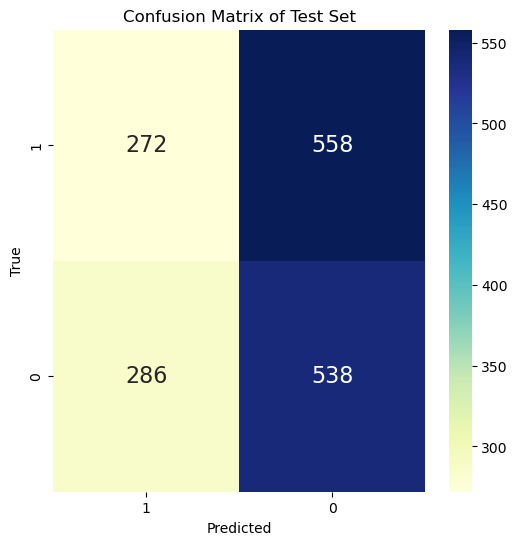

In [22]:
cm_test = confusion_matrix(Y_test, y_hat, labels = [1, 0])
plt.figure(figsize = (6,6))
s = sns.heatmap(cm_test, annot= True, fmt = 'd', annot_kws={'size': 16}, 
                cmap ='YlGnBu', xticklabels=[1, 0], yticklabels=[1, 0])
_ = s.set_xlabel('Predicted')
_ = s.set_ylabel('True')
_ = s.set_title('Confusion Matrix of Test Set')

In [23]:
ret = p_v.df[['BTC-close']].iloc[-Y_test.shape[0]:, :]
ret['hold'] = (1 + ret['BTC-close']).cumprod()
ret['signal'] = y_hat
ret['strategy'] = (1 + ret['BTC-close'] * ret['signal']).cumprod()
ret

,BTC-close,hold,signal,strategy
2022-07-18 07:00:00+00:00,0.001829,1.001829,0,1.000000
2022-07-18 08:00:00+00:00,-0.001316,1.000511,0,1.000000
2022-07-18 09:00:00+00:00,0.000122,1.000633,0,1.000000
2022-07-18 10:00:00+00:00,-0.002458,0.998173,0,1.000000
2022-07-18 11:00:00+00:00,-0.003189,0.994991,0,1.000000
...,...,...,...,...
2022-09-25 00:00:00+00:00,0.001259,0.852899,1,1.020606
2022-09-25 01:00:00+00:00,0.000494,0.853320,1,1.021110
2022-09-25 02:00:00+00:00,-0.000934,0.852523,1,1.020157
2022-09-25 03:00:00+00:00,0.004757,0.856579,1,1.025009


<AxesSubplot:>

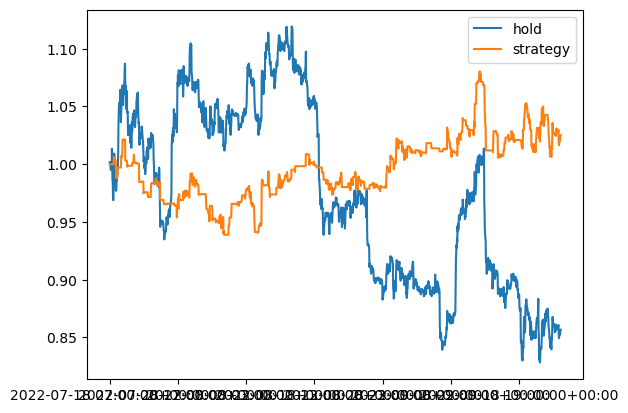

In [24]:
ret[['hold', 'strategy']].plot()